# Вступление
Данный iphyton notebook является примером решения задачи Titanic: Machine Learning from Disaster с сайта kaggle.com. Ссылка на задачу: https://www.kaggle.com/c/titanic

В задаче требуется предсказать выживание пассажиров Титаника из файла test.csv, имея размеченные данные для пассажиров из файла train.csv.

Решение задачи реализуется в три основных этапа:
    1. Анализ признаков пассажиров.
    2. Обработка признаков в соответствии с результатами анализа.
    3. Применение алгоритмов машинного обучения для нахождения ответа на задачу.
    
Основой данного решения послужила следующая работа: https://www.kaggle.com/startupsci/titanic-data-science-solutions.

# Подключение библиотек

In [1]:
# анализ признаков и их обработка
import pandas as pd
import numpy as np

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# машинное обучение
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# отключение предупреждений для большой наглядности
import warnings
warnings.filterwarnings("ignore")

# Анализ признаков

Читаем данные из файлов train.csv и test.csv и создаём новый датафрейм combine для одновременного изменения обоих датафреймов.

In [2]:
# Reading data sets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

Получаем общее представление о количестве признаков, их названии и количестве пропущенных значений.

In [3]:
train_df.info()
print('_' * 40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

Отсюда сразу видно, что использование признака Cabin нецелесообразно, количество пропущенных значений превосходит заполненные.

Смотрим на общий вид данных.

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Получаем общую сводку о численных признаках.

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


И о категориальных.

In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


Признак Ticket так же не будем использовать, потому что только 20% значений являются не уникальными и значения имеют слишком сложную структуру (буквенный префикс, иногда отсутствующий, и числовая часть, что делает интерпретацию практически невозможной без дополнительной информации).

Признак Pclass показывает класс билета, логично, что чем он выше, тем больше шанс выжить, так как богатые пассажиры являются более приоритетной целью для спасения. Проверим корреляцию Survived и Pclass.

In [7]:
train_df[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Наше предположение подтвердилось.

Теперь посмотрим на Sex.

In [8]:
train_df[["Sex", "Survived"]].groupby(
    ['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Выходит, что у женщины шанс выжить был значительно выше, значит признак Sex полезный.

Посмотрим на признак SibSp, он показывает количество братьев, сестёр и супругов.

In [9]:
train_df[["SibSp", "Survived"]].groupby(
    ['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Тепреь на признак Parch, который отображает количство родителей и детей на корабле.

In [10]:
train_df[["Parch", "Survived"]].groupby(
    ['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Оба этих признака не являются информативными. Так что можно попробовать их объединить.

Остальные признаки либо не являются категориальными, либо не являются числовыми. На них проще посмотреть в виде графика.

# Визуализация

Посмотрим на зависимость Survived от Age, построив график для тех, кто выжил, и тех, кто нет, на котором ось абсцисс отвечает за возраст, а ось ординат за количество.

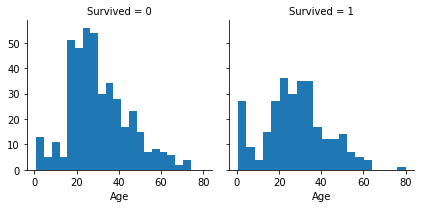

In [11]:
grid = sns.FacetGrid(train_df, col='Survived')
grid.map(plt.hist, 'Age', bins=20)

Видно, что у маленьких детей и очень старых людей крайне высокий процент выживаемости, так что признак Age является полезым и подлежит дальнейшей обработке.

Оценим корреляцию между Pclass, Age и Survived.

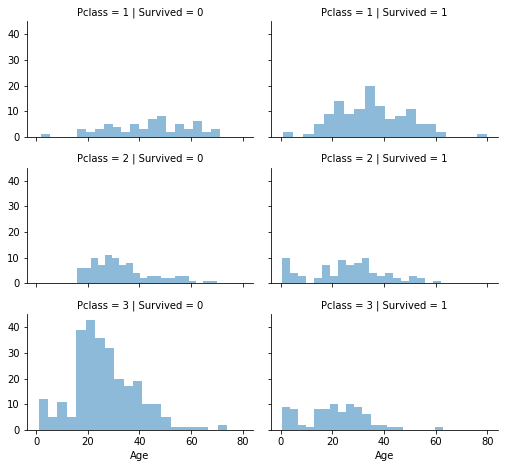

In [12]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Ещё раз видим подтверждение тому, что чем выше класс, тем больше процентов спаслось. Однако если в первом классе в основном спаслись взрослые, то во втором в ярко видно большое количество спасшихся маленьких детей. Это наблюдение показвает корреляцию между Age и Pclass.

Посмотрим на связь между категориальными признаками Embarked (порт посадки), Sex и Pclass.

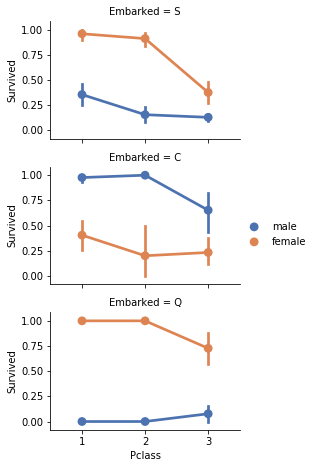

In [13]:
# Categorical
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

В порту C выживаемость мужчин выше чем женщин, что крайне необычно, это показывает связь Embarked и Sex.

Чем ниже класс, тем более размыта разница между мужчинами и женщинами, что показывает свзязь Pclass и Sex.

Проверим связь категориальных признаков Embarked, Sex и Fare (цена билета).

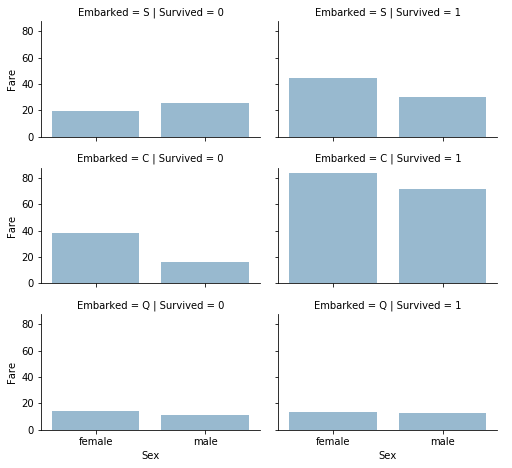

In [14]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

Видна связь Fare и Survived, чем выше цена билета, тем выше выживаемость.

Так же видна связь с портом и с полом.

# Обработка признаков

Первым делом удаляем признаки, от которых решили избавляться, это Ticket и Cabin.

In [15]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

Теперб разберёмся с признаком Name. Логично, что имена сами по себе слабо соотносятся с выживаемостью, к тому же среди них слишом много уникальных значений. Однако в именах содержатся титулы Miss, Mister и т.д., попробуем из выделить в новый признак Title.

In [16]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

Посмотрим как соотносится Title и Sex.

In [17]:
# Analysing correlation between Title and Sex
print(pd.crosstab(train_df['Title'], train_df['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


И увидим, что Title напрямую определяет пол пассажира.

Можно заметить, что многие уникальные значения Title встречаются относительно небольшое количество раз. В связи с этим, сократим их количество, путём объединения редких значений и изменения имени некоторых на более классические названия.

In [18]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
         'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Посмотрим на корреляцию между Title и Survived.

In [19]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Как мы видим, она присутствует.

Избавимся от лишних теперь признаков Name и PassangerId.

In [20]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

Преобразуем признак Sex в численный, для удобства работы.

In [21]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

# Age: заполнение пропущенных значений и обработка
В признаке Age имеются пропущенные значения, для их заполнения можно воспользоваться корреляцией Age, Pclass и Sex, в которой поможет ещё раз убедиться график снизу.

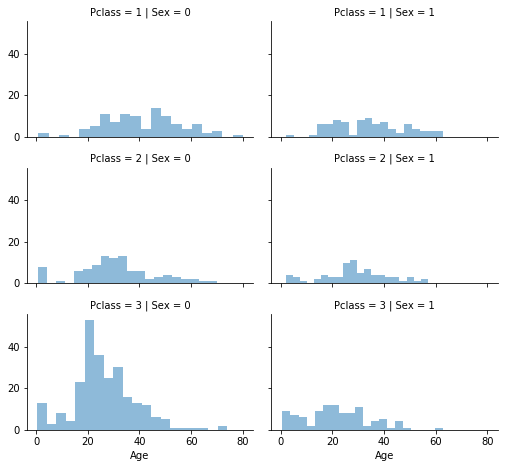

In [22]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Для заполнения Age можно смотреть среднее значение призанака, можно медианное, можно подставлять случайное в окрестности среднего, но мы восспользуемся корреляцией с классом и полом. А именно, посчитаем 6 значений возраста для 6 различных комбинаций Age и Pclass, взяв медианное значение возраста людей с такой парой Age и Pclass и заполним пропущенные значения исхоля и этих значений.

In [23]:
guess_ages = np.zeros((2, 3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) &
                               (dataset['Pclass'] == j + 1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i, j] = int(age_guess / 0.5 + 0.5) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset['Age'].isnull()) & (dataset['Sex'] == i) &
                        (dataset.Pclass == j + 1), 'Age'] = guess_ages[i, j]


Ранее мы заметили, что признак Age достаточно хорошо показывает свзяь с выживаемостью для определённых возрастных интервалов (маленькие дети, большие дети, взрослые и т.д.), поэтому создадим признак AgeBand, разбив Age на интервалы.

In [24]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

Посмотрим на связь AgeBand и Survived.

In [25]:
# Correlation between AgeBand and Survived
print(train_df[['AgeBand', 'Survived']].groupby(
    ['AgeBand'], as_index=False).mean().sort_values(
    by='AgeBand', ascending=True))

            AgeBand  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.336714
2  (32.252, 48.168]  0.412844
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909


Она чётко выраженна.

Заменим значение признака Age на номер интервала, которому он принадлежит.

In [26]:
for dataset in combine:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 5

Удалим AgeBand за ненадобностью.

In [27]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

# Parch и SibSp: объединение двух признаков в один
Ранее мы уже выяснили, что Parch и SibSp не обладают собственной ценностью, однако можно попробовать создать из них новый признак. Этим и займёмся.

Создадим признак FamilySize, показывающий общее количество родственников на корабле.

In [28]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

Оценим информативность нового признака.

In [29]:
train_df[['FamilySize', 'Survived']].groupby(
    ['FamilySize'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Новый признак тоже не оказался высокоинформативным, так что попробуем создать признак IsAlone, который показывает, один ли человек на корабле.

In [30]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

Посмотрим на связь IsAlone и Survived.

In [31]:
train_df[['IsAlone', 'Survived']].groupby(
    ['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Она ярковыраженна, так что оставим этот признак.

Удалим Parch, SibSp, and FamilySize в предпочтение IsAlone.

In [32]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

Создадим искуственный признак Age\*Class путём умножения Age на Pclass.

In [33]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

# Embarked и Fare: заполнение пропущенных значений и обработка

В первую очередь, найдём моду среди заполненых значений Embarked.

In [34]:
freq_port = train_df.Embarked.dropna().mode()[0]

Заполним пропущенные значения полученной модой.

In [35]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

Проверяем связь Embarked и Survived.

In [36]:
train_df[['Embarked', 'Survived']].groupby(
    ['Embarked'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Она присутствует.

Приступим к работе с признаком Fare, заполнив единственное пропущенное значение медианой.

In [37]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

Создадим новый признак FareBand, показывающий интервалы Fare, подобно AgeBand.

In [38]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

Оценим информативность нового признака.

In [39]:
# Correlation between FareBand and Survived
train_df[['FareBand', 'Survived']].groupby(
    ['FareBand'], as_index=False).mean().sort_values(
    by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


FareBand достаточно информативен.

Заменим значения Fare на номер интервала, к которому они принадлежат.

In [40]:
for dataset in combine:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

Удалим FareBand за ненадобностью.

In [41]:
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

# Обработка категориальных признаков
Для применения алгоритмов машинного обучения все признаки должны быть числовыми. У нас есть два не числовых категориальных признака, Emabarked и Title. Мы можем просто присвоить число каждому значению, но свойство категориальности будет потеряно. Для выхода из ситуации используют dumpy (one hot) кодирование.

In [42]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

В результате, мы получили следующее представление данных.

In [43]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,0,1.0,0,0,3.0,0,0,1,0,0,1,0,0
1,1,1,1,2.0,3,0,2.0,1,0,0,0,0,0,1,0
2,1,3,1,1.0,1,1,3.0,0,0,1,0,1,0,0,0
3,1,1,1,2.0,3,0,2.0,0,0,1,0,0,0,1,0
4,0,3,0,2.0,1,1,6.0,0,0,1,0,0,1,0,0


# Машинное обучение
Обучим несколько алгоритмов машинного обучения для выбора лучшего по встроенной метрики качества и после найдём ответ при помощи лучшего из них.

Выделим набор данных для обучения, набор ответов для обучения и тестовые данные, для которых мы хотим получить ответ.

In [44]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

Логистическая регрессия.

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_log = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

Логистическая регрессия вычисляет ответ по взвешенной сумме, то есть оценивает важность признаков. Мы можем проверить наши предположения о их важности.

Для начала получим коэффициенты признаков из обученного алгоритма.

In [46]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

Теперь посмотрим на связь коэффициентов и выживаемости.

In [47]:
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,1.771877
9,Title_Master,1.538147
12,Title_Mrs,0.949059
6,Embarked_C,0.735060
4,IsAlone,0.509767
7,Embarked_Q,0.480490
10,Title_Miss,0.202688
8,Embarked_S,0.149966
3,Fare,-0.060986
5,Age*Class,-0.119814


Dummy признаки нерепрезентативны при таком подходе, однако мы видим, что Sex и Pclass являются самыми сильными признаками.

Метод опорных векторов.

In [48]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

K ближайших соседей.

In [49]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

Наивный Байес.

In [50]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

Перцептрон.

In [51]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_perceptron = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

Линейная вариация метода опорных веторов.

In [52]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_linear_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

Стохастический градиентный спуск.

In [53]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_sgd = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

Решающее дерево.

In [54]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_decision_tree = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

Случайный лес.

In [55]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_random_forest = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

Градиентный бустинг.

In [56]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, Y_train)
Y_pred_grad_boost = grad_boost.predict(X_test)
acc_grad_boost = round(grad_boost.score(X_train, Y_train) * 100, 2)

Сравнение результатов разных алгоритмов.

In [57]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting'],
    'Score': [acc_svc, acc_knn, acc_log,
              acc_random_forest, acc_gaussian, acc_perceptron,
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_grad_boost]
    })
print(models.sort_values(by='Score', ascending=False))

                        Model  Score
3               Random Forest  86.64
8               Decision Tree  86.64
1                         KNN  84.51
9           Gradient Boosting  84.40
0     Support Vector Machines  83.28
7                  Linear SVC  82.04
2         Logistic Regression  80.58
5                  Perceptron  80.47
4                 Naive Bayes  79.46
6  Stochastic Gradient Decent  78.68


Как мы видим, случайный лес выдаёт лучший результат, на равне с обычным решающим деревом.

Осталось только записать лучший результат (случайный лес) в файл.

In [58]:
# Writing submission to the file
submission = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': Y_pred_random_forest
    })
submission.to_csv('prediction_solution.csv', index=False)